The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
# Cài đặt một số thư viện cần thiết
!pip install d2l==0.15.1 

# Implementation of Softmax Regression from Scratch
:label:`sec_softmax_scratch`

Just as we implemented linear regression from scratch,
we believe that softmax regression
is similarly fundamental and you ought to know
the gory details of how to implement it yourself.
We will work with the Fashion-MNIST dataset, just introduced in :numref:`sec_fashion_mnist`,
setting up a data iterator with batch size 256.


In [ ]:
# Import thư viện vào chương trình
from d2l import tensorflow as d2l   # import thư viện bổ sung cho tensorflow của d2l
import tensorflow as tf   
from IPython import display # Thư viện để hiển thị ảnh trên notebook

In [ ]:
batch_size = 256 # Thêm batch_zize 
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size) # Download bộ fashion - mnist dataset, chia 2 tập train và test, mỗi mini-batch có 256 ảnh
# Trong đó train_iter là một iterator có thể loop qua các mini-batch dùng để train(mỗi mini-batch sẽ có 256 objects) 
# Trong đó test_iter là một iterator có thể loop qua các mini-batch dùng để test(mỗi mini-batch sẽ có 256 objects) 

## Initializing Model Parameters

As in our linear regression example,
each example here will be represented by a fixed-length vector.
Each example in the raw dataset is a $28 \times 28$ image.
In this section, we will flatten each image,
treating them as vectors of length 784.
In the future, we will talk about more sophisticated strategies
for exploiting the spatial structure in images,
but for now we treat each pixel location as just another feature.

Recall that in softmax regression,
we have as many outputs as there are classes.
Because our dataset has 10 classes,
our network will have an output dimension of 10.
Consequently, our weights will constitute a $784 \times 10$ matrix
and the biases will constitute a $1 \times 10$ row vector.
As with linear regression, we will initialize our weights `W`
with Gaussian noise and our biases to take the initial value 0.


In [ ]:
num_inputs = 784 # Một bức ảnh có kích thước 28*28 pixels -> flatten tạo thành một vector trong không gian 784 chiều -> mỗi x sẽ có 784 inputs dầu vào
num_outputs = 10 # Trong bộ dataset này, ta sẽ chia ra làm 10 classes -> output sẽ là xác suất OneVsRest của từng loại

# ['t-shirt', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
W = tf.Variable(tf.random.normal(shape=(num_inputs, num_outputs), # Khởi tạo W theo phân phối gausse -> là một ma trận 784 x 10 ứng với số inputs và outputs
                                 mean=0, stddev=0.01)) # Giá trị kì vọng = 0 và độ lệch chuẩn = 0.01
b = tf.Variable(tf.zeros(num_outputs)) # Khởi tạo biases với giá trị khởi tạo là 0

## Defining the Softmax Operation

Before implementing the softmax regression model,
let us briefly review how the sum operator works
along specific dimensions in a tensor,
as discussed in :numref:`subseq_lin-alg-reduction` and :numref:`subseq_lin-alg-non-reduction`.
Given a matrix `X` we can sum over all elements (by default) or only
over elements in the same axis,
i.e., the same column (axis 0) or the same row (axis 1).
Note that if `X` is a tensor with shape (2, 3)
and we sum over the columns,
the result will be a vector with shape (3,).
When invoking the sum operator,
we can specify to keep the number of axes in the original tensor,
rather than collapsing out the dimension that we summed over.
This will result in a two-dimensional tensor with shape (1, 3).


In [ ]:
X = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]]) # Khởi tạo một ma trận X 2x3
tf.reduce_sum(X, 0, keepdims=True), tf.reduce_sum(X, 1, keepdims=True) # Tính tổng từng trục của X, keepdims=True để không bị gộp ma trận cột thành ma trận hàng

(<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[5., 7., 9.]], dtype=float32)>,
 <tf.Tensor: shape=(2, 1), dtype=float32, numpy=
 array([[ 6.],
        [15.]], dtype=float32)>)

We are now ready to implement the softmax operation.
Recall that softmax consists of three steps:
i) we exponentiate each term (using `exp`);
ii) we sum over each row (we have one row per example in the batch)
to get the normalization constant for each example;
iii) we divide each row by its normalization constant,
ensuring that the result sums to 1.
Before looking at the code, let us recall
how this looks expressed as an equation:

$$
\mathrm{softmax}(\mathbf{X})_{ij} = \frac{\exp(\mathbf{X}_{ij})}{\sum_k \exp(\mathbf{X}_{ik})}.
$$

The denominator, or normalization constant,
is also sometimes called the *partition function*
(and its logarithm is called the log-partition function).
The origins of that name are in [statistical physics](https://en.wikipedia.org/wiki/Partition_function_(statistical_mechanics))
where a related equation models the distribution
over an ensemble of particles.


In [ ]:
def softmax(X): # Khai báo hàm softmax truyền vào một ma trận X
    X_exp = tf.exp(X) # X_exp là một ma trận với mỗi giá trị là e^xij 
    partition = tf.reduce_sum(X_exp, 1, keepdims=True) # Tính tổng từng trục của X_exp và giữ nguyên số chiều của ma trận
    return X_exp / partition  # trả về một ma trận với mỗi aij là xác suất được phân vào class j của vector xi

As you can see, for any random input,
we turn each element into a non-negative number.
Moreover, each row sums up to 1,
as is required for a probability.


In [ ]:
X = tf.random.normal((2, 5), 0, 1) # Khởi tạo một ma trận 2x5 với kì vọng là 0 và độ lệch chuẩn là 1
X_prob = softmax(X) # tính softmax của ma trận X
X_prob, tf.reduce_sum(X_prob, 1) # Xuất ra X_prob và tổng từng hàng của X_prob
# Nhận xét: mỗi hàng đều có tổng xấp xỉ 1 -> tổng các xác suất = 1 -> sự khác biệt của softmax vs logistic regression

(<tf.Tensor: shape=(2, 5), dtype=float32, numpy=
 array([[0.34889966, 0.2638116 , 0.20318234, 0.12954965, 0.05455678],
        [0.11596616, 0.21910927, 0.11256724, 0.49993986, 0.05241746]],
       dtype=float32)>,
 <tf.Tensor: shape=(2,), dtype=float32, numpy=array([1., 1.], dtype=float32)>)

Note that while this looks correct mathematically,
we were a bit sloppy in our implementation
because we failed to take precautions against numerical overflow or underflow
due to large or very small elements of the matrix.

## Defining the Model

Now that we have defined the softmax operation,
we can implement the softmax regression model.
The below code defines how the input is mapped to the output through the network.
Note that we flatten each original image in the batch
into a vector using the `reshape` function
before passing the data through our model.


In [ ]:
def net(X): # Khai báo một cái mạng -> mạng bao gồm bước W*X + b -> sau đó cho vô biến đổi softmax
    return softmax(tf.matmul(tf.reshape(X, (-1, W.shape[0])), W) + b)
# Hàm trên sẽ trả về y_hat

## Defining the Loss Function

Next, we need to implement the cross-entropy loss function,
as introduced in :numref:`sec_softmax`.
This may be the most common loss function
in all of deep learning because, at the moment,
classification problems far outnumber regression problems.

Recall that cross-entropy takes the negative log-likelihood
of the predicted probability assigned to the true label.
Rather than iterating over the predictions with a Python for-loop
(which tends to be inefficient),
we can pick all elements by a single operator.
Below, we create a toy data `y_hat`
with 2 examples of predicted probabilities over 3 classes.
Then we pick the probability of the first class in the first example
and the probability of the third class in the second example.


In [ ]:
y_hat = tf.constant([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]]) # Khởi tạo ma trận y_hat để làm ví dụ, chứa xác suât được trả về sau khi qua softmax operation
y = tf.constant([0, 2]) # Khởi tạo một vector y là vector chứa các class mà xi thuộc về
tf.boolean_mask(y_hat, tf.one_hot(y, depth=y_hat.shape[-1])) # Lấy ra giá trị ứng với onehot theo y từ y_hat

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.1, 0.5], dtype=float32)>

Now we can implement the cross-entropy loss function efficiently with just one line of code.


In [ ]:
def cross_entropy(y_hat, y): # Tính cross entropy
    return -tf.math.log(tf.boolean_mask(
        y_hat, tf.one_hot(y, depth=y_hat.shape[-1])))
# Trả về - log của xác suất onehot
cross_entropy(y_hat, y)
# Nhận xét: xác suất càng nhỏ thì entropy loss càng lớn

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([2.3025851, 0.6931472], dtype=float32)>

## Classification Accuracy

Given the predicted probability distribution `y_hat`,
we typically choose the class with the highest predicted probability
whenever we must output a hard prediction.
Indeed, many applications require that we make a choice.
Gmail must categorize an email into "Primary", "Social", "Updates", or "Forums".
It might estimate probabilities internally,
but at the end of the day it has to choose one among the classes.

When predictions are consistent with the label class `y`, they are correct.
The classification accuracy is the fraction of all predictions that are correct.
Although it can be difficult to optimize accuracy directly (it is not differentiable),
it is often the performance measure that we care most about,
and we will nearly always report it when training classifiers.

To compute accuracy we do the following.
First, if `y_hat` is a matrix,
we assume that the second dimension stores prediction scores for each class.
We use `argmax` to obtain the predicted class by the index for the largest entry in each row.
Then we compare the predicted class with the ground-truth `y` elementwise.
Since the equality operator `==` is sensitive to data types,
we convert `y_hat`'s data type to match that of `y`.
The result is a tensor containing entries of 0 (false) and 1 (true).
Taking the sum yields the number of correct predictions.


In [ ]:
def accuracy(y_hat, y):  # Khởi tạo hàm tính độ chính xác của predicted_y (y_hat) so với output đúng (y)
    """Compute the number of correct predictions."""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = tf.argmax(y_hat, axis=1)  # Trả về vị trí mà số đó lớn nhất theo hàng
    cmp = tf.cast(y_hat, y.dtype) == y # Chuyển kiểu dữ liệu của y_hat cho giống với y và trả về 1 mảng [True, False] cmp là y_hat == y hay không?
    return float(tf.reduce_sum(tf.cast(cmp, y.dtype))) # Đếm số lượng True 

We will continue to use the variables `y_hat` and `y`
defined before
as the predicted probability distributions and labels, respectively.
We can see that the first example's prediction class is 2
(the largest element of the row is 0.6 with the index 2),
which is inconsistent with the actual label, 0.
The second example's prediction class is 2
(the largest element of the row is 0.5 with the index of 2),
which is consistent with the actual label, 2.
Therefore, the classification accuracy rate for these two examples is 0.5.


In [ ]:
accuracy(y_hat, y) / len(y) # trả về độ chính xác của y_hat so với y

0.5

Similarly, we can evaluate the accuracy for any model `net` on a dataset
that is accessed via the data iterator `data_iter`.


In [ ]:
def evaluate_accuracy(net, data_iter):  # Hàm tính độ chính xác của model trên bộ data test
    """Compute the accuracy for a model on a dataset."""
    metric = Accumulator(2)  # Khai báo biến metric dùng để tính toán độ chính xác (biến metric có thể coi như là một bộ đếm tổng của n tập với n = 2 trong trường hợp này để lưu độ chính xác và kích thước y)
    for X, y in data_iter: 
        metric.add(accuracy(net(X), y), tf.size(y).numpy()) # Gọi hàm để cộng vô các thành phần trong metric
    return metric[0] / metric[1] # trả về độ chính xác = metric[0] / metric[1] (tổng accuracy chia cho số ảnh)

Here `Accumulator` is a utility class to accumulate sums over multiple variables.
In the above `evaluate_accuracy` function,
we create 2 variables in the `Accumulator` instance for storing both
the number of correct predictions and the number of predictions, respectively.
Both will be accumulated over time as we iterate over the dataset.


In [ ]:
class Accumulator:  # Khởi tạo class Accumulator
    """For accumulating sums over `n` variables."""
    def __init__(self, n):  # overide lại method __init__
        self.data = [0.0] * n # Tạo một mảng n chiều

    def add(self, *args): # *arg để truyển vào một list các arguments 
        self.data = [a + float(b) for a, b in zip(self.data, args)] # Hàm add này sẽ cộng element-wise data[i] hiện có với args thêm vào

    def reset(self):
        self.data = [0.0] * len(self.data) # reset mảng data về 0 như ban đầu

    def __getitem__(self, idx):
        return self.data[idx] # lấy item tại index idx

Because we initialized the `net` model with random weights,
the accuracy of this model should be close to random guessing,
i.e., 0.1 for 10 classes.


In [ ]:
evaluate_accuracy(net, test_iter) # Tính độ chính xác trên bộ data test

0.0694

## Training

The training loop for softmax regression should look strikingly familiar
if you read through our implementation
of linear regression in :numref:`sec_linear_scratch`.
Here we refactor the implementation to make it reusable.
First, we define a function to train for one epoch.
Note that `updater` is a general function to update the model parameters,
which accepts the batch size as an argument.
It can be either a wrapper of the `d2l.sgd` function
or a framework's built-in optimization function.


In [ ]:
def train_epoch_ch3(net, train_iter, loss, updater):  #@save
    """The training loop defined in Chapter 3."""
    # Sum of training loss, sum of training accuracy, no. of examples
    # Khai báo metric để tính toán training accuracy và loss
    metric = Accumulator(3)
    for X, y in train_iter:
        # Compute gradients and update parameters
        # Tính đạo hàm và cập nhật parameters 
        with tf.GradientTape() as tape:
            y_hat = net(X)
            # Keras implementations for loss takes (labels, predictions)
            # instead of (predictions, labels) that users might implement
            # in this book, e.g. `cross_entropy` that we implemented above
            if isinstance(loss, tf.keras.losses.Loss): # Kiểm tra xem loss đã đúng kiểu dữ liệu chưa
                l = loss(y, y_hat)
            else:
                l = loss(y_hat, y)
        if isinstance(updater, tf.keras.optimizers.Optimizer): # Kiểm tra xem updater đã đúng kiểu dữ liệu chưa 
            params = net.trainable_variables                   # Nếu đúng kiểu dữ liệu thì sẽ gọi từ thư viện
            grads = tape.gradient(l, params)                   # Tính đạo hàm hàm loss theo các tham số
            updater.apply_gradients(zip(grads, params))        # Gọi updater để cập nhật giá trị của W
        else:
            updater(X.shape[0], tape.gradient(l, updater.params)) # Gọi updater để cập nhật giá trị của W
        # Keras loss by default returns the average loss in a batch
        l_sum = l * float(tf.size(y)) if isinstance(        # tính tổng loss
            loss, tf.keras.losses.Loss) else tf.reduce_sum(l)
        metric.add(l_sum, accuracy(y_hat, y), tf.size(y)) # Thêm tổng loss, tổng accuracy và số lượng ảnh ứng với mỗi minibatch vào metric
    # Return training loss and training accuracy
    return metric[0] / metric[2], metric[1] / metric[2] # trả về training loss và training accuracy

Before showing the implementation of the training function,
we define a utility class that plot data in animation.
Again, it aims to simplify code in the rest of the book.


In [ ]:
class Animator:  #@save
    """For plotting data in animation."""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        '''
            xlabel, ylabel: tên trục x, tên trục y
            legend: có chú thích hay không
            xscale, yscale: cách scale trục x và trục y
            fmt: định dạng các đường đồ thị
            xlim, ylim: giới hạn độ dài của các trục x, trục y
        '''
        # Incrementally plot multiple lines
        if legend is None:
            legend = []
        d2l.use_svg_display() # hiển thị dưới dạng svg
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize) # chia plot thành fig và axes
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # Use a lambda function to capture arguments
        # tạo lamda function để config đồ thị
        self.config_axes = lambda: d2l.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # Add multiple data points into the figure
        if not hasattr(y, "__len__"): # Nếu y không có thuộc tính len 
            y = [y]                    
        n = len(y)  # Gán n bằng len y
        if not hasattr(x, "__len__"):
            x = [x] * n  # làm cho biến x có số lượng phần tử = y để cho phép zip bên dưới
        if not self.X:
            self.X = [[] for _ in range(n)] 
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)): # zip dùng để duyệt 2 mảng cùng lúc
            if a is not None and b is not None: # enumerate dùng để thêm index cho phần tử duyệt
                self.X[i].append(a) # Gắn thêm cách dữ kiện vào X để vẽ plot
                self.Y[i].append(b) # # Gắn thêm cách dữ kiện vào Y để vẽ plot
        self.axes[0].cla() # xóa axe hiện tại
        for x, y, fmt in zip(self.X, self.Y, self.fmts): # với mỗi đường trong X sẽ tạo một cái đoạn thẳng trên cái plot -> kéo dài đoạn cũ
            self.axes[0].plot(x, y, fmt)
        self.config_axes()  # Config đồ thị 
        display.display(self.fig) # Hiển thị plot mới
        display.clear_output(wait=True) # Để tự động xóa plot cũ, update plot mới

The following training function then
trains a model `net` on a training dataset accessed via `train_iter`
for multiple epochs, which is specified by `num_epochs`.
At the end of each epoch,
the model is evaluated on a testing dataset accessed via `test_iter`.
We will leverage the `Animator` class to visualize
the training progress.


In [ ]:
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):  #@save
    """Train a model (defined in Chapter 3)."""
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9], # Khai báo animator
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):  # Với mỗi epoch
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater) # nhận về loss và accuracy của quá trình train
        test_acc = evaluate_accuracy(net, test_iter)    # nhận về accuracy của model trên tập test
        animator.add(epoch + 1, train_metrics + (test_acc,)) # Cập nhật animator để vẽ đồ thị
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5, train_loss # đảm bảo training loss < 0.5 -> Nếu không sẽ quăng Error báo lỗi
    assert train_acc <= 1 and train_acc > 0.7, train_acc # đảm bảo 0.7 < training Ac < 1 -> Nếu không sẽ quăng Error báo lỗi
    assert test_acc <= 1 and test_acc > 0.7, test_acc # đảm bảo 0.7 < test ac < 1 -> Nếu không sẽ quăng Error báo lỗi

As an implementation from scratch,
we use the minibatch stochastic gradient descent defined in :numref:`sec_linear_scratch`
to optimize the loss function of the model with a learning rate 0.1.


In [ ]:
class Updater():  # Định nghĩa class Updater()
    """For updating parameters using minibatch stochastic gradient descent."""
    def __init__(self, params, lr): # Khởi tạo tham số và learning rate
        self.params = params
        self.lr = lr

    def __call__(self, batch_size, grads): 
        d2l.sgd(self.params, grads, self.lr, batch_size) # Tính minibatch stochastic gradient descent

updater = Updater([W, b], lr=0.1) # khai báo updater với biến tham số đầu vào là [W, b] và learning rate = 0.1

Now we train the model with 10 epochs.
Note that both the number of epochs (`num_epochs`),
and learning rate (`lr`) are adjustable hyperparameters.
By changing their values, we may be able
to increase the classification accuracy of the model.


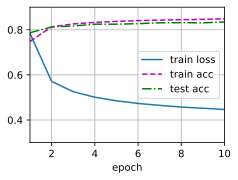

In [ ]:
num_epochs = 10 # Số training epochs (môi epoch thì sẽ duyệt qua toàn bộ mini-batch)
train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, updater) # Bắt đầu train 

## Prediction

Now that training is complete,
our model is ready to classify some images.
Given a series of images,
we will compare their actual labels
(first line of text output)
and the predictions from the model
(second line of text output).


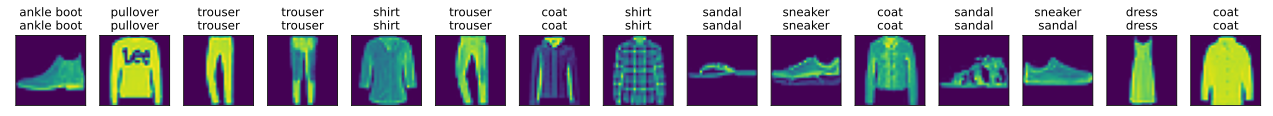

In [ ]:
def predict_ch3(net, test_iter, n=15):  # Dự đoán kết quả trong đó n là số ảnh cần dự đoán
    """Predict labels (defined in Chapter 3)."""
    for X, y in test_iter: # Lấy ra X và y
        break
    trues = d2l.get_fashion_mnist_labels(y) # Lấy truth - grounding (kết quả đúng) từ dataset
    preds = d2l.get_fashion_mnist_labels(tf.argmax(net(X), axis=1)) # lấy kết quả mà model predict ra được
    titles = [true +'\n' + pred for true, pred in zip(trues, preds)] # tạo title = kết quả đúng + kết quả dự đoán
    d2l.show_images(
        tf.reshape(X[0:n], (n, 28, 28)), 1, n, titles=titles[0:n]) # Hiện ra các ảnh kèm label
predict_ch3(net, test_iter)

## Summary

* With softmax regression, we can train models for multiclass classification.
* The training loop of softmax regression is very similar to that in linear regression: retrieve and read data, define models and loss functions, then train models using optimization algorithms. As you will soon find out, most common deep learning models have similar training procedures.

## Exercises

1. In this section, we directly implemented the softmax function based on the mathematical definition of the softmax operation. What problems might this cause? Hint: try to calculate the size of $\exp(50)$.
1. The function `cross_entropy` in this section was implemented according to the definition of the cross-entropy loss function.  What could be the problem with this implementation? Hint: consider the domain of the logarithm.
1. What solutions you can think of to fix the two problems above?
1. Is it always a good idea to return the most likely label? For example, would you do this for medical diagnosis?
1. Assume that we want to use softmax regression to predict the next word based on some features. What are some problems that might arise from a large vocabulary?


[Discussions](https://discuss.d2l.ai/t/225)
